In [ ]:
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

# STS Dataset

In [2]:
column_names = ['genre', 'filename', 'year', 'id', 'score', 'sentence1', 'sentence2']

df_train = pd.read_csv('data/sts-train.csv', sep='\t', names=column_names, skiprows=1, on_bad_lines='skip')
print(f"Train shape: {df_train.shape}")

df_dev = pd.read_csv('data/sts-dev.csv', sep='\t', names=column_names, skiprows=1, on_bad_lines='skip')
print(f"Dev shape: {df_dev.shape}")

# Fix the test file by using quoting=3 (QUOTE_NONE) to ignore quotes
df_test = pd.read_csv('data/sts-test.csv', sep='\t', names=column_names, skiprows=1, 
                      on_bad_lines='skip', quoting=3)
print(f"Test shape: {df_test.shape}")

# Clean up any remaining issues
df_train = df_train.dropna()
df_dev = df_dev.dropna()
df_test = df_test.dropna()

print(f"Final shapes - Train: {df_train.shape}, Dev: {df_dev.shape}, Test: {df_test.shape}")

Train shape: (5508, 7)
Dev shape: (1442, 7)
Test shape: (1094, 7)
Final shapes - Train: (5505, 7), Dev: (1440, 7), Test: (1094, 7)


In [3]:
df_train.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
1,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
2,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
3,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
4,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.


# Word2Vec

In [4]:
# Load Word2Vec vectors
print("Loading Word2Vec vectors...")
word2vec_model = KeyedVectors.load_word2vec_format('vectors/GoogleNews-vectors-negative300.bin', binary=True)
print(f"Word2Vec vocabulary size: {len(word2vec_model.key_to_index)}")
print(f"Vector dimensions: {word2vec_model.vector_size}")

# Example: get vector for a word
if 'king' in word2vec_model:
    king_vector = word2vec_model['king']
    print(f"Vector for 'king': shape {king_vector.shape}")
    print(f"Norm of 'king' vector: {np.linalg.norm(king_vector):.4f}")

Loading Word2Vec vectors...
Word2Vec vocabulary size: 3000000
Vector dimensions: 300
Vector for 'king': shape (300,)
Norm of 'king' vector: 2.9023


# GloVe

In [5]:
# Load the GloVe vectors directly
print("Loading GloVe vectors directly from original file...")
glove_model = KeyedVectors.load_word2vec_format('vectors/glove.840B.300d.txt', binary=False, no_header=True)
print(f"GloVe vocabulary size: {len(glove_model.key_to_index)}")
print(f"Vector dimensions: {glove_model.vector_size}")

# Example: get vector for a word
if 'king' in glove_model:
    king_vector_glove = glove_model['king']
    print(f"Vector for 'king' (GloVe): shape {king_vector_glove.shape}")
    print(f"Norm of 'king' vector (GloVe): {np.linalg.norm(king_vector_glove):.4f}")

Loading GloVe vectors directly from original file...
GloVe vocabulary size: 2196016
Vector dimensions: 300
Vector for 'king' (GloVe): shape (300,)
Norm of 'king' vector (GloVe): 7.1417


# Information Content

COMPREHENSIVE INFORMATION CONTENT ANALYSIS
Total sentences to analyze: 16078

Calculating Word2Vec IC...
Processing 16078 sentences for ALL DATASETS...
  Processed 0/16078 sentences...
  Processed 1000/16078 sentences...
  Processed 2000/16078 sentences...
  Processed 3000/16078 sentences...
  Processed 4000/16078 sentences...
  Processed 5000/16078 sentences...
  Processed 6000/16078 sentences...
  Processed 7000/16078 sentences...
  Processed 8000/16078 sentences...
  Processed 9000/16078 sentences...
  Processed 10000/16078 sentences...
  Processed 11000/16078 sentences...
  Processed 12000/16078 sentences...
  Processed 13000/16078 sentences...
  Processed 14000/16078 sentences...
  Processed 15000/16078 sentences...
  Processed 16000/16078 sentences...
  Found 11941 unique words with vectors in ALL DATASETS

Calculating GloVe IC...
Processing 16078 sentences for ALL DATASETS...
  Processed 0/16078 sentences...
  Processed 1000/16078 sentences...
  Processed 2000/16078 sentences...

C:\Users\alvar\AppData\Local\Temp\ipykernel_4556\331764996.py:253: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ic_data, labels=['Word2Vec', 'GloVe'])


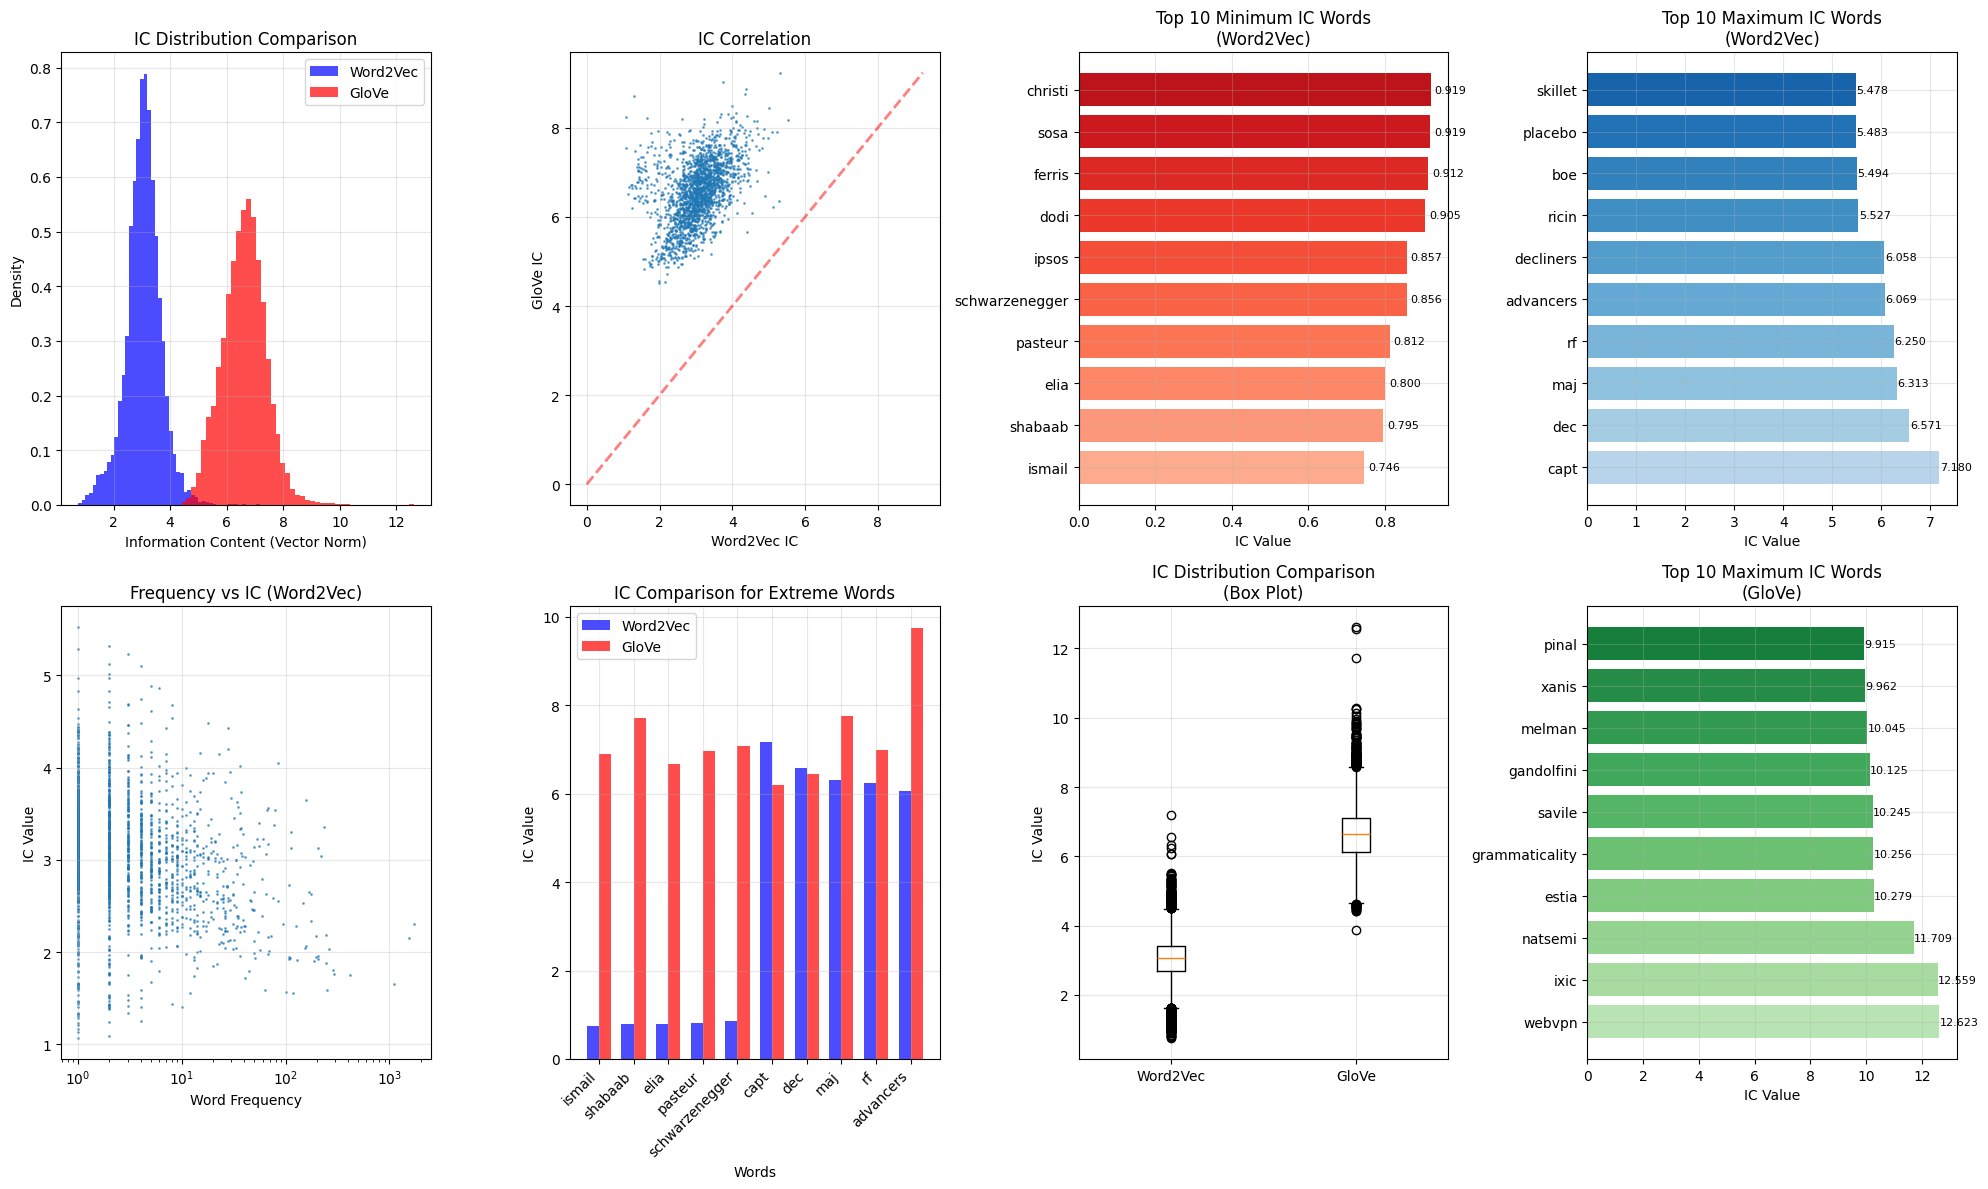

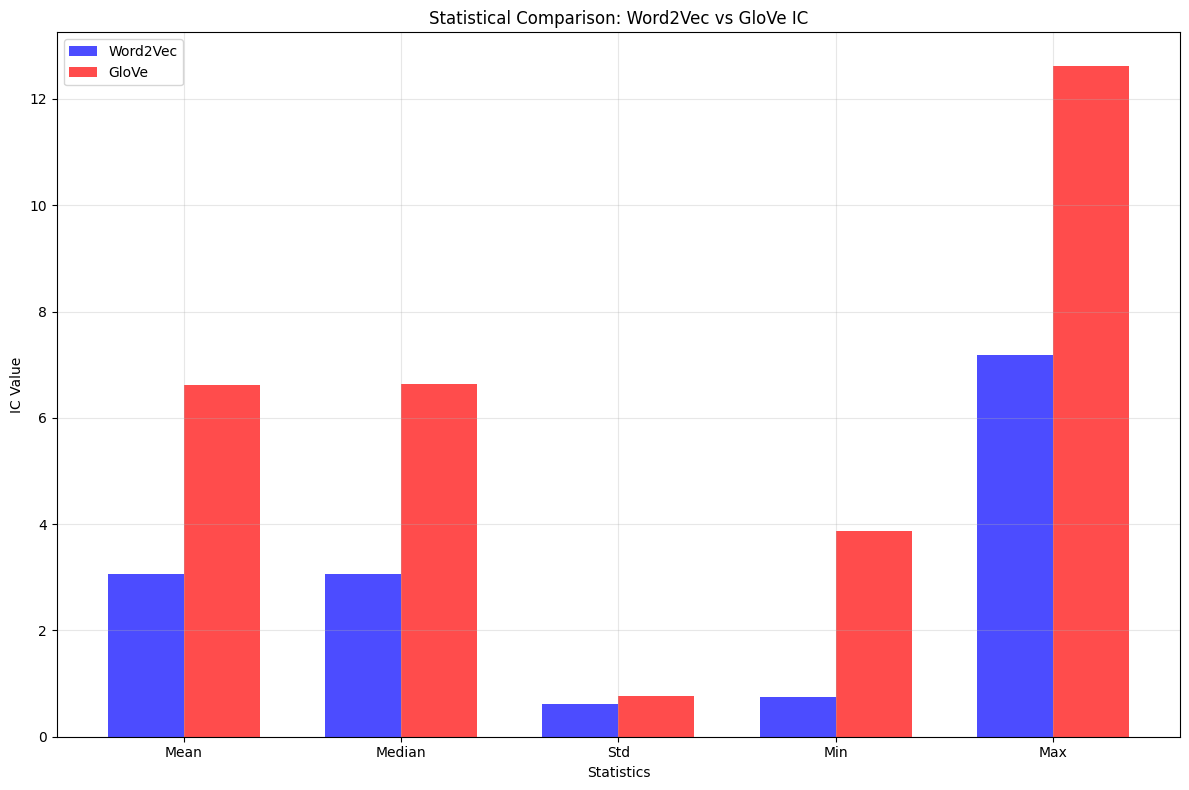


ANALYSIS COMPLETE
Total unique words analyzed: 11937
Word2Vec vocabulary coverage: 11941 words
GloVe vocabulary coverage: 12960 words
IC correlation between models: 0.4254


In [6]:
def calculate_ic_norms(model, sentences, dataset_name=""):
    """
    Calculate Information Content (IC) as vector norm for words in sentences
    
    Args:
        model: Word2Vec or GloVe model
        sentences: List of sentences (strings)
        dataset_name: Name of the dataset for logging
    
    Returns:
        dict: word -> IC (norm) mapping
        dict: word -> frequency mapping
    """
    word_ic = defaultdict(list)
    word_freq = Counter()
    
    print(f"Processing {len(sentences)} sentences for {dataset_name}...")
    
    for i, sentence in enumerate(sentences):
        if i % 1000 == 0:
            print(f"  Processed {i}/{len(sentences)} sentences...")
            
        words = re.findall(r'\b[a-zA-Z]+\b', sentence.lower())
        
        for word in words:
            word_freq[word] += 1
            if word in model:
                norm = np.linalg.norm(model[word])
                word_ic[word].append(norm)
    
    word_ic_avg = {word: np.mean(norms) for word, norms in word_ic.items()}
    print(f"  Found {len(word_ic_avg)} unique words with vectors in {dataset_name}")
    return word_ic_avg, dict(word_freq)

def get_extreme_ic_words(ic_dict, n=20):
    """
    Get n words with minimum and maximum IC
    
    Args:
        ic_dict: Dictionary mapping words to IC values
        n: Number of words to return for each extreme
    
    Returns:
        tuple: (min_ic_words, max_ic_words) where each is a list of (word, ic) tuples
    """
    sorted_words = sorted(ic_dict.items(), key=lambda x: x[1])
    min_ic_words = sorted_words[:n]
    max_ic_words = sorted_words[-n:][::-1]  # Reverse to get descending order
    return min_ic_words, max_ic_words

def print_ic_results(ic_dict, freq_dict, model_name, min_words, max_words):
    """
    Print formatted IC results for a model
    
    Args:
        ic_dict: Dictionary mapping words to IC values
        freq_dict: Dictionary mapping words to frequencies
        model_name: Name of the model (e.g., "Word2Vec", "GloVe")
        min_words: List of (word, ic) tuples for minimum IC words
        max_words: List of (word, ic) tuples for maximum IC words
    """
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS")
    print(f"{'='*60}")
    
    print("20 words with MINIMUM IC (most general/common):")
    print("-" * 50)
    for i, (word, ic) in enumerate(min_words, 1):
        freq = freq_dict.get(word, 0)
        print(f"{i:2d}. {word:15s}: IC={ic:.4f}, Freq={freq}")
    
    print("\n20 words with MAXIMUM IC (most specific/rare):")
    print("-" * 50)
    for i, (word, ic) in enumerate(max_words, 1):
        freq = freq_dict.get(word, 0)
        print(f"{i:2d}. {word:15s}: IC={ic:.4f}, Freq={freq}")

def calculate_ic_statistics(ic_values, model_name):
    """
    Calculate and print IC statistics for a model
    
    Args:
        ic_values: List of IC values
        model_name: Name of the model
    """
    print(f"\n{model_name} IC Statistics:")
    print(f"  Mean IC: {np.mean(ic_values):.4f}")
    print(f"  Median IC: {np.median(ic_values):.4f}")
    print(f"  Std IC: {np.std(ic_values):.4f}")
    print(f"  Min IC: {np.min(ic_values):.4f}")
    print(f"  Max IC: {np.max(ic_values):.4f}")

def compare_models(word2vec_ic, glove_ic, word2vec_freq, glove_freq):
    """
    Compare Word2Vec and GloVe models
    
    Args:
        word2vec_ic: Word2Vec IC dictionary
        glove_ic: GloVe IC dictionary
        word2vec_freq: Word2Vec frequency dictionary
        glove_freq: GloVe frequency dictionary
    
    Returns:
        dict: Comparison results
    """
    common_words = set(word2vec_ic.keys()) & set(glove_ic.keys())
    print(f"\nCommon words between models: {len(common_words)}")
    
    # Correlation analysis
    w2v_ic_common = [word2vec_ic[word] for word in common_words]
    glove_ic_common = [glove_ic[word] for word in common_words]
    correlation = np.corrcoef(w2v_ic_common, glove_ic_common)[0, 1]
    print(f"Correlation between Word2Vec and GloVe IC values: {correlation:.4f}")
    
    # Find words with largest differences
    ic_comparison = []
    for word in common_words:
        w2v_ic = word2vec_ic[word]
        glove_ic_val = glove_ic[word]
        ic_comparison.append({
            'word': word,
            'word2vec_ic': w2v_ic,
            'glove_ic': glove_ic_val,
            'difference': abs(w2v_ic - glove_ic_val)
        })
    
    ic_comparison.sort(key=lambda x: x['difference'], reverse=True)
    
    print(f"\nTop 10 words with largest IC differences between models:")
    print("-" * 60)
    for i, item in enumerate(ic_comparison[:10], 1):
        print(f"{i:2d}. {item['word']:15s}: W2V={item['word2vec_ic']:.4f}, GloVe={item['glove_ic']:.4f}, Diff={item['difference']:.4f}")
    
    return {
        'common_words': len(common_words),
        'correlation': correlation,
        'ic_comparison': ic_comparison
    }

def create_ic_visualizations(word2vec_ic, glove_ic, word2vec_freq, glove_freq, 
                           word2vec_min, word2vec_max, glove_min, glove_max):
    """
    Create comprehensive visualizations for IC analysis
    
    Args:
        word2vec_ic, glove_ic: IC dictionaries
        word2vec_freq, glove_freq: Frequency dictionaries
        word2vec_min, word2vec_max, glove_min, glove_max: Extreme IC words
    """
    print(f"\n{'='*60}")
    print("CREATING VISUALIZATIONS")
    print(f"{'='*60}")
    
    # Get common words for comparison
    common_words = set(word2vec_ic.keys()) & set(glove_ic.keys())
    common_words_list = list(common_words)[:2000]
    w2v_ic_plot = [word2vec_ic[word] for word in common_words_list]
    glove_ic_plot = [glove_ic[word] for word in common_words_list]
    
    # Main visualization figure
    plt.figure(figsize=(20, 12))
    
    # 1. IC Distribution comparison
    plt.subplot(2, 4, 1)
    w2v_ic_values = list(word2vec_ic.values())
    glove_ic_values = list(glove_ic.values())
    plt.hist(w2v_ic_values, bins=50, alpha=0.7, label='Word2Vec', density=True, color='blue')
    plt.hist(glove_ic_values, bins=50, alpha=0.7, label='GloVe', density=True, color='red')
    plt.xlabel('Information Content (Vector Norm)')
    plt.ylabel('Density')
    plt.title('IC Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Scatter plot of IC values
    plt.subplot(2, 4, 2)
    plt.scatter(w2v_ic_plot, glove_ic_plot, alpha=0.6, s=1)
    plt.xlabel('Word2Vec IC')
    plt.ylabel('GloVe IC')
    plt.title('IC Correlation')
    max_val = max(max(w2v_ic_plot), max(glove_ic_plot))
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2)
    plt.grid(True, alpha=0.3)
    
    # 3. Top 10 minimum IC words (Word2Vec)
    plt.subplot(2, 4, 3)
    min_words = [word for word, _ in word2vec_min[:10]]
    min_ic_values = [ic for _, ic in word2vec_min[:10]]
    colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(min_words)))
    bars = plt.barh(range(len(min_words)), min_ic_values, color=colors)
    plt.yticks(range(len(min_words)), min_words)
    plt.xlabel('IC Value')
    plt.title('Top 10 Minimum IC Words\n(Word2Vec)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, min_ic_values)):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontsize=8)
    
    # 4. Top 10 maximum IC words (Word2Vec)
    plt.subplot(2, 4, 4)
    max_words = [word for word, _ in word2vec_max[:10]]
    max_ic_values = [ic for _, ic in word2vec_max[:10]]
    colors = plt.cm.Blues(np.linspace(0.3, 0.8, len(max_words)))
    bars = plt.barh(range(len(max_words)), max_ic_values, color=colors)
    plt.yticks(range(len(max_words)), max_words)
    plt.xlabel('IC Value')
    plt.title('Top 10 Maximum IC Words\n(Word2Vec)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, max_ic_values)):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontsize=8)
    
    # 5. Frequency vs IC relationship (Word2Vec)
    plt.subplot(2, 4, 5)
    common_words_freq = [word2vec_freq.get(word, 0) for word in common_words_list]
    plt.scatter(common_words_freq, w2v_ic_plot, alpha=0.6, s=1)
    plt.xlabel('Word Frequency')
    plt.ylabel('IC Value')
    plt.title('Frequency vs IC (Word2Vec)')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    
    # 6. IC comparison for extreme words
    plt.subplot(2, 4, 6)
    extreme_words = [word for word, _ in word2vec_min[:5] + word2vec_max[:5]]
    w2v_extreme = [word2vec_ic[word] for word in extreme_words]
    glove_extreme = [glove_ic[word] for word in extreme_words]
    
    x = np.arange(len(extreme_words))
    width = 0.35
    plt.bar(x - width/2, w2v_extreme, width, label='Word2Vec', alpha=0.7, color='blue')
    plt.bar(x + width/2, glove_extreme, width, label='GloVe', alpha=0.7, color='red')
    plt.xlabel('Words')
    plt.ylabel('IC Value')
    plt.title('IC Comparison for Extreme Words')
    plt.xticks(x, extreme_words, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Box plot comparison
    plt.subplot(2, 4, 7)
    ic_data = [w2v_ic_values, glove_ic_values]
    plt.boxplot(ic_data, labels=['Word2Vec', 'GloVe'])
    plt.ylabel('IC Value')
    plt.title('IC Distribution Comparison\n(Box Plot)')
    plt.grid(True, alpha=0.3)
    
    # 8. Top 10 maximum IC words (GloVe)
    plt.subplot(2, 4, 8)
    max_words_glove = [word for word, _ in glove_max[:10]]
    max_ic_values_glove = [ic for _, ic in glove_max[:10]]
    colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(max_words_glove)))
    bars = plt.barh(range(len(max_words_glove)), max_ic_values_glove, color=colors)
    plt.yticks(range(len(max_words_glove)), max_words_glove)
    plt.xlabel('IC Value')
    plt.title('Top 10 Maximum IC Words\n(GloVe)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, max_ic_values_glove)):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Additional summary plot
    create_summary_statistics_plot(w2v_ic_values, glove_ic_values)

def create_summary_statistics_plot(w2v_ic_values, glove_ic_values):
    """Create summary statistics comparison plot"""
    plt.figure(figsize=(12, 8))
    
    stats_comparison = {
        'Mean': [np.mean(w2v_ic_values), np.mean(glove_ic_values)],
        'Median': [np.median(w2v_ic_values), np.median(glove_ic_values)],
        'Std': [np.std(w2v_ic_values), np.std(glove_ic_values)],
        'Min': [np.min(w2v_ic_values), np.min(glove_ic_values)],
        'Max': [np.max(w2v_ic_values), np.max(glove_ic_values)]
    }
    
    x = np.arange(len(stats_comparison))
    width = 0.35
    
    plt.bar(x - width/2, [stats_comparison[key][0] for key in stats_comparison.keys()], 
           width, label='Word2Vec', alpha=0.7, color='blue')
    plt.bar(x + width/2, [stats_comparison[key][1] for key in stats_comparison.keys()], 
           width, label='GloVe', alpha=0.7, color='red')
    
    plt.xlabel('Statistics')
    plt.ylabel('IC Value')
    plt.title('Statistical Comparison: Word2Vec vs GloVe IC')
    plt.xticks(x, list(stats_comparison.keys()))
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main analysis function (now cleaner and more focused)
def comprehensive_ic_analysis(word2vec_model, glove_model, df_train, df_dev, df_test, create_plots=True):
    """
    Comprehensive Information Content analysis with integrated visualizations
    
    Args:
        word2vec_model: Loaded Word2Vec model
        glove_model: Loaded GloVe model
        df_train, df_dev, df_test: STS datasets
        create_plots: Whether to create visualizations
    
    Returns:
        dict: Analysis results
    """
    print(f"{'='*60}")
    print("COMPREHENSIVE INFORMATION CONTENT ANALYSIS")
    print(f"{'='*60}")
    
    # Combine all datasets
    all_sentences = (df_train['sentence1'].tolist() + df_train['sentence2'].tolist() + 
                    df_dev['sentence1'].tolist() + df_dev['sentence2'].tolist() + 
                    df_test['sentence1'].tolist() + df_test['sentence2'].tolist())
    
    print(f"Total sentences to analyze: {len(all_sentences)}")
    
    # Calculate IC for both models
    print("\nCalculating Word2Vec IC...")
    word2vec_ic, word2vec_freq = calculate_ic_norms(word2vec_model, all_sentences, "ALL DATASETS")
    
    print("\nCalculating GloVe IC...")
    glove_ic, glove_freq = calculate_ic_norms(glove_model, all_sentences, "ALL DATASETS")
    
    # Get extreme IC words
    word2vec_min, word2vec_max = get_extreme_ic_words(word2vec_ic, 20)
    glove_min, glove_max = get_extreme_ic_words(glove_ic, 20)
    
    # Print results
    print_ic_results(word2vec_ic, word2vec_freq, "Word2Vec", word2vec_min, word2vec_max)
    print_ic_results(glove_ic, glove_freq, "GloVe", glove_min, glove_max)
    
    # Statistical analysis
    print(f"\n{'='*60}")
    print("STATISTICAL ANALYSIS")
    print(f"{'='*60}")
    
    w2v_ic_values = list(word2vec_ic.values())
    glove_ic_values = list(glove_ic.values())
    
    calculate_ic_statistics(w2v_ic_values, "Word2Vec")
    calculate_ic_statistics(glove_ic_values, "GloVe")
    
    # Model comparison
    comparison_results = compare_models(word2vec_ic, glove_ic, word2vec_freq, glove_freq)
    
    # Visualizations
    if create_plots:
        create_ic_visualizations(word2vec_ic, glove_ic, word2vec_freq, glove_freq,
                               word2vec_min, word2vec_max, glove_min, glove_max)
    
    # Return results
    results = {
        'word2vec_ic': word2vec_ic,
        'glove_ic': glove_ic,
        'word2vec_freq': word2vec_freq,
        'glove_freq': glove_freq,
        'word2vec_min': word2vec_min,
        'word2vec_max': word2vec_max,
        'glove_min': glove_min,
        'glove_max': glove_max,
        'correlation': comparison_results['correlation'],
        'common_words': comparison_results['common_words'],
        'total_words_w2v': len(word2vec_ic),
        'total_words_glove': len(glove_ic)
    }
    
    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE")
    print(f"{'='*60}")
    print(f"Total unique words analyzed: {comparison_results['common_words']}")
    print(f"Word2Vec vocabulary coverage: {len(word2vec_ic)} words")
    print(f"GloVe vocabulary coverage: {len(glove_ic)} words")
    print(f"IC correlation between models: {comparison_results['correlation']:.4f}")
    
    return results

# Run the analysis
results = comprehensive_ic_analysis(word2vec_model, glove_model, df_train, df_dev, df_test, create_plots=True)

COMPREHENSIVE INFORMATION CONTENT ANALYSIS
Total sentences to analyze: 16078

Calculating Word2Vec IC...
Processing 16078 sentences for ALL DATASETS...
  Processed 0/16078 sentences...
  Processed 1000/16078 sentences...
  Processed 2000/16078 sentences...
  Processed 3000/16078 sentences...
  Processed 4000/16078 sentences...
  Processed 5000/16078 sentences...
  Processed 6000/16078 sentences...
  Processed 7000/16078 sentences...
  Processed 8000/16078 sentences...
  Processed 9000/16078 sentences...
  Processed 10000/16078 sentences...
  Processed 11000/16078 sentences...
  Processed 12000/16078 sentences...
  Processed 13000/16078 sentences...
  Processed 14000/16078 sentences...
  Processed 15000/16078 sentences...
  Processed 16000/16078 sentences...
  Found 11941 unique words with vectors in ALL DATASETS

Calculating GloVe IC...
Processing 16078 sentences for ALL DATASETS...
  Processed 0/16078 sentences...
  Processed 1000/16078 sentences...
  Processed 2000/16078 sentences...

C:\Users\alvar\AppData\Local\Temp\ipykernel_4556\331764996.py:253: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ic_data, labels=['Word2Vec', 'GloVe'])


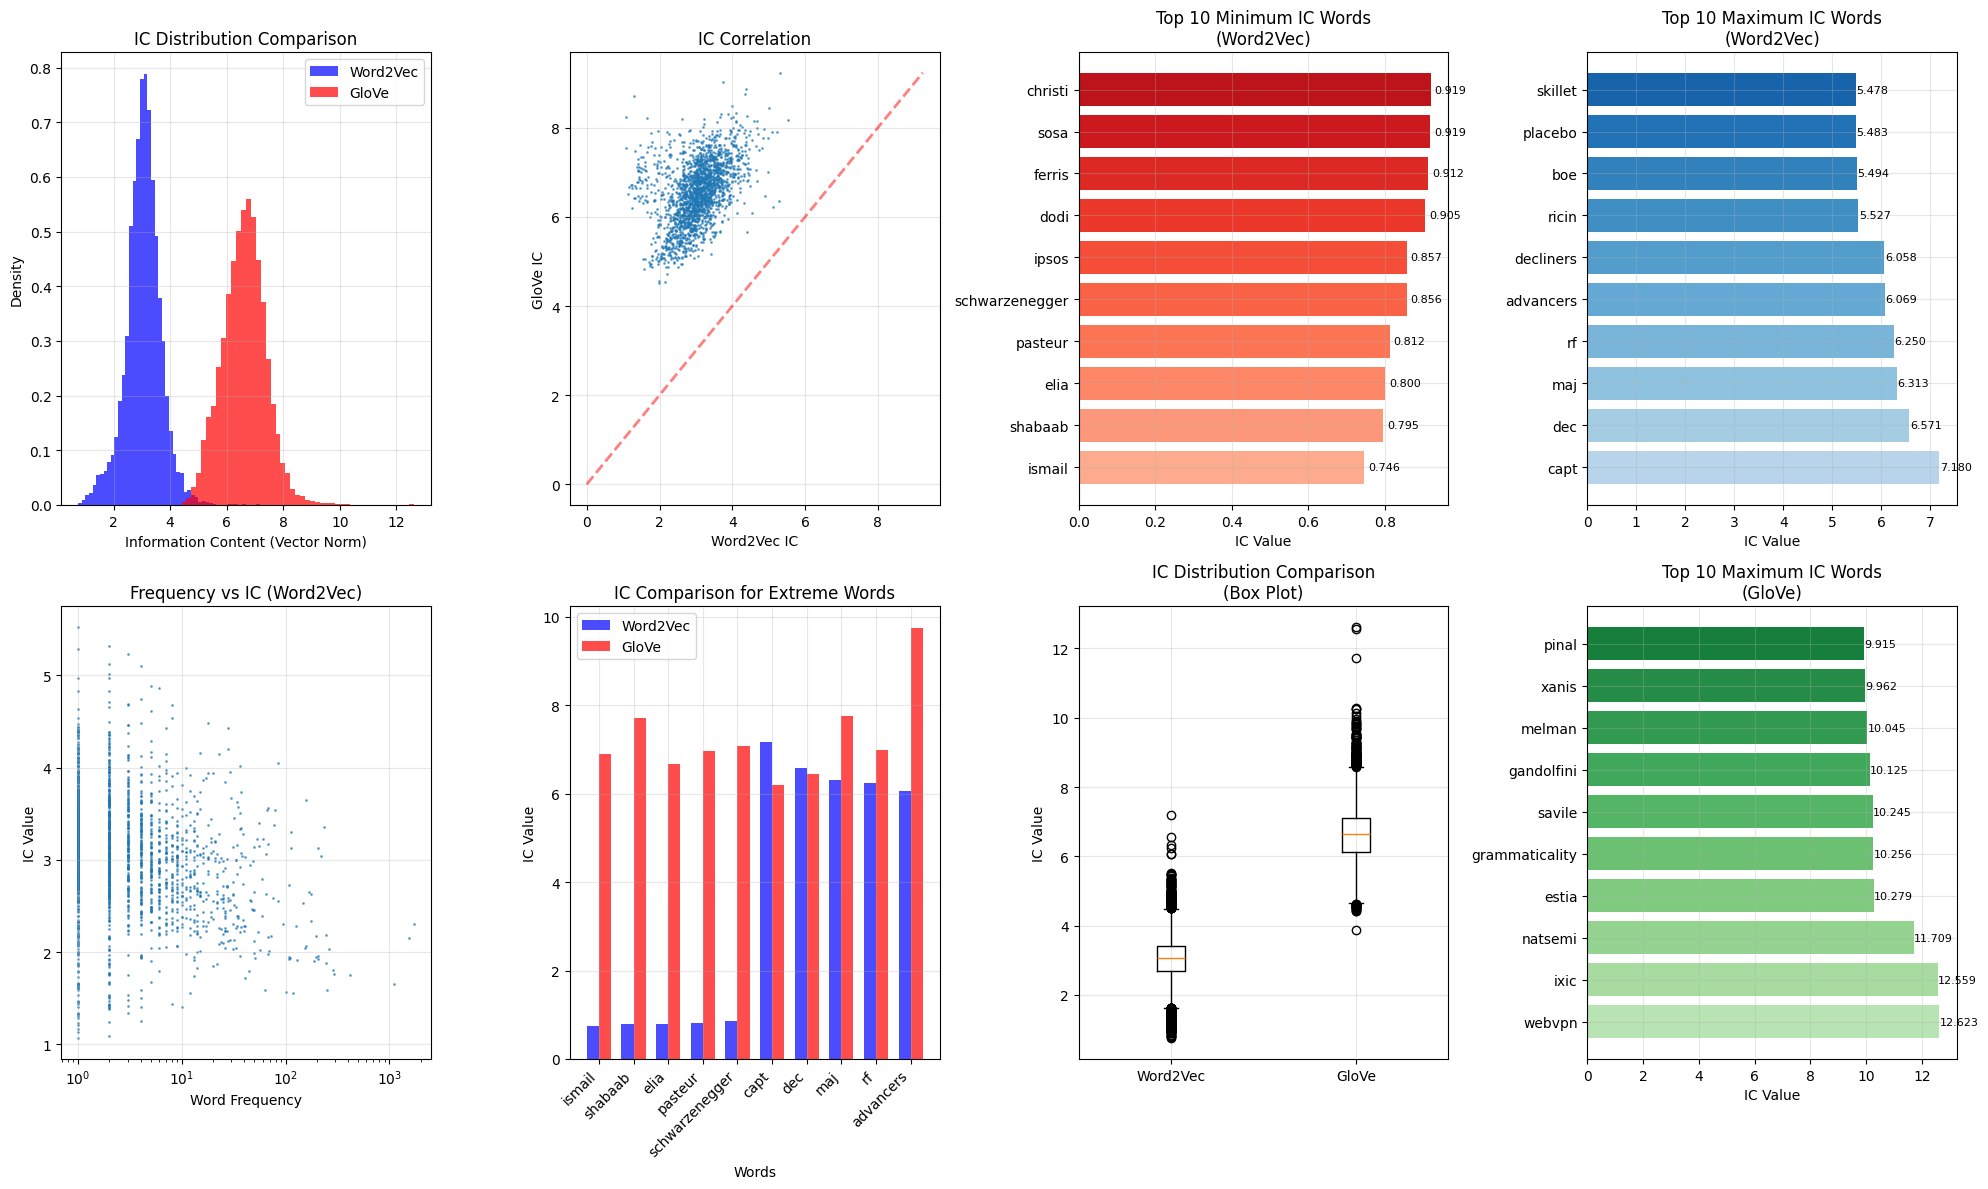

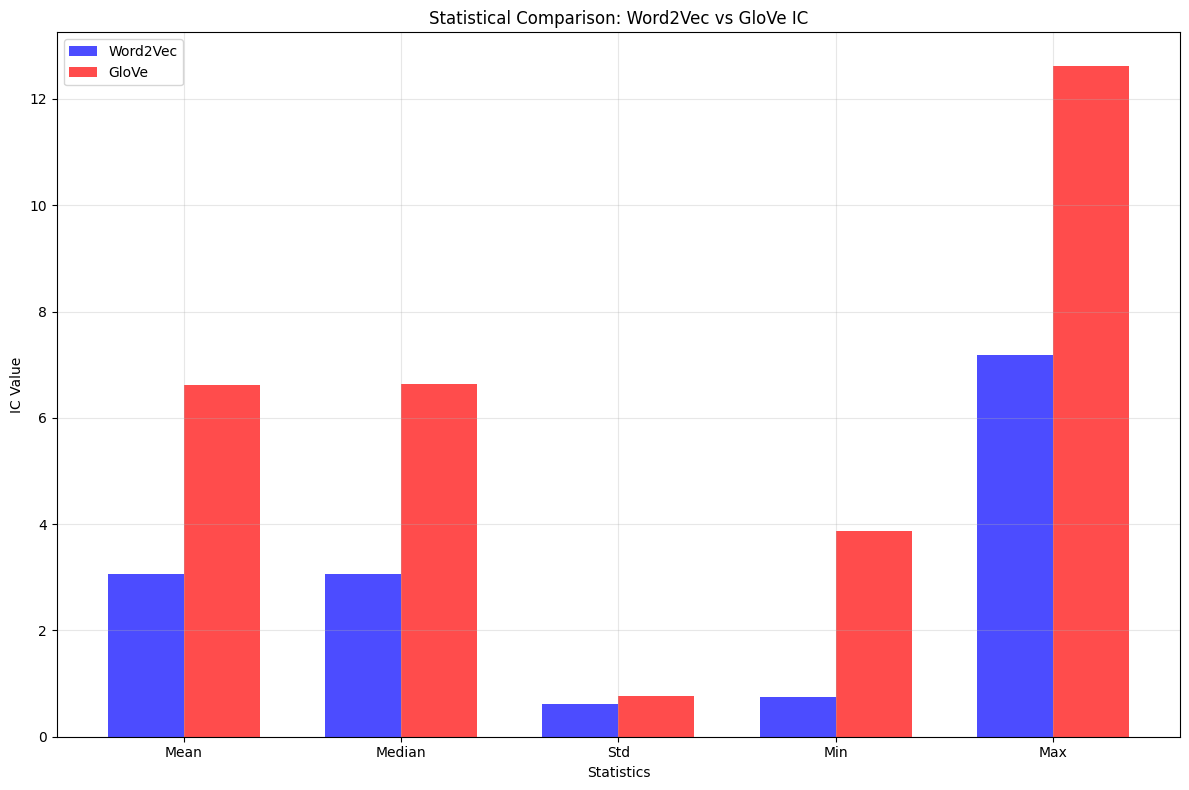


ANALYSIS COMPLETE
Total unique words analyzed: 11937
Word2Vec vocabulary coverage: 11941 words
GloVe vocabulary coverage: 12960 words
IC correlation between models: 0.4254


In [ ]:
def calculate_ic_norms(model, sentences, dataset_name=""):
    """
    Calculate Information Content (IC) as vector norm for words in sentences
    
    Args:
        model: Word2Vec or GloVe model
        sentences: List of sentences (strings)
        dataset_name: Name of the dataset for logging
    
    Returns:
        dict: word -> IC (norm) mapping
        dict: word -> frequency mapping
    """
    word_ic = defaultdict(list)
    word_freq = Counter()
    
    print(f"Processing {len(sentences)} sentences for {dataset_name}...")
    
    for i, sentence in enumerate(sentences):
        if i % 1000 == 0:
            print(f"  Processed {i}/{len(sentences)} sentences...")
            
        words = re.findall(r'\b[a-zA-Z]+\b', sentence.lower())
        
        for word in words:
            word_freq[word] += 1
            if word in model:
                norm = np.linalg.norm(model[word])
                word_ic[word].append(norm)
    
    word_ic_avg = {word: np.mean(norms) for word, norms in word_ic.items()}
    print(f"  Found {len(word_ic_avg)} unique words with vectors in {dataset_name}")
    return word_ic_avg, dict(word_freq)

def get_extreme_ic_words(ic_dict, n=20):
    """
    Get n words with minimum and maximum IC
    
    Args:
        ic_dict: Dictionary mapping words to IC values
        n: Number of words to return for each extreme
    
    Returns:
        tuple: (min_ic_words, max_ic_words) where each is a list of (word, ic) tuples
    """
    sorted_words = sorted(ic_dict.items(), key=lambda x: x[1])
    min_ic_words = sorted_words[:n]
    max_ic_words = sorted_words[-n:][::-1]  # Reverse to get descending order
    return min_ic_words, max_ic_words

def print_ic_results(ic_dict, freq_dict, model_name, min_words, max_words):
    """
    Print formatted IC results for a model
    
    Args:
        ic_dict: Dictionary mapping words to IC values
        freq_dict: Dictionary mapping words to frequencies
        model_name: Name of the model (e.g., "Word2Vec", "GloVe")
        min_words: List of (word, ic) tuples for minimum IC words
        max_words: List of (word, ic) tuples for maximum IC words
    """
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS")
    print(f"{'='*60}")
    
    print("20 words with MINIMUM IC (most general/common):")
    print("-" * 50)
    for i, (word, ic) in enumerate(min_words, 1):
        freq = freq_dict.get(word, 0)
        print(f"{i:2d}. {word:15s}: IC={ic:.4f}, Freq={freq}")
    
    print("\n20 words with MAXIMUM IC (most specific/rare):")
    print("-" * 50)
    for i, (word, ic) in enumerate(max_words, 1):
        freq = freq_dict.get(word, 0)
        print(f"{i:2d}. {word:15s}: IC={ic:.4f}, Freq={freq}")

def calculate_ic_statistics(ic_values, model_name):
    """
    Calculate and print IC statistics for a model
    
    Args:
        ic_values: List of IC values
        model_name: Name of the model
    """
    print(f"\n{model_name} IC Statistics:")
    print(f"  Mean IC: {np.mean(ic_values):.4f}")
    print(f"  Median IC: {np.median(ic_values):.4f}")
    print(f"  Std IC: {np.std(ic_values):.4f}")
    print(f"  Min IC: {np.min(ic_values):.4f}")
    print(f"  Max IC: {np.max(ic_values):.4f}")

def compare_models(word2vec_ic, glove_ic, word2vec_freq, glove_freq):
    """
    Compare Word2Vec and GloVe models
    
    Args:
        word2vec_ic: Word2Vec IC dictionary
        glove_ic: GloVe IC dictionary
        word2vec_freq: Word2Vec frequency dictionary
        glove_freq: GloVe frequency dictionary
    
    Returns:
        dict: Comparison results
    """
    common_words = set(word2vec_ic.keys()) & set(glove_ic.keys())
    print(f"\nCommon words between models: {len(common_words)}")
    
    # Correlation analysis
    w2v_ic_common = [word2vec_ic[word] for word in common_words]
    glove_ic_common = [glove_ic[word] for word in common_words]
    correlation = np.corrcoef(w2v_ic_common, glove_ic_common)[0, 1]
    print(f"Correlation between Word2Vec and GloVe IC values: {correlation:.4f}")
    
    # Find words with largest differences
    ic_comparison = []
    for word in common_words:
        w2v_ic = word2vec_ic[word]
        glove_ic_val = glove_ic[word]
        ic_comparison.append({
            'word': word,
            'word2vec_ic': w2v_ic,
            'glove_ic': glove_ic_val,
            'difference': abs(w2v_ic - glove_ic_val)
        })
    
    ic_comparison.sort(key=lambda x: x['difference'], reverse=True)
    
    print(f"\nTop 10 words with largest IC differences between models:")
    print("-" * 60)
    for i, item in enumerate(ic_comparison[:10], 1):
        print(f"{i:2d}. {item['word']:15s}: W2V={item['word2vec_ic']:.4f}, GloVe={item['glove_ic']:.4f}, Diff={item['difference']:.4f}")
    
    return {
        'common_words': len(common_words),
        'correlation': correlation,
        'ic_comparison': ic_comparison
    }

def create_ic_visualizations(word2vec_ic, glove_ic, word2vec_freq, glove_freq, 
                           word2vec_min, word2vec_max, glove_min, glove_max):
    """
    Create comprehensive visualizations for IC analysis
    
    Args:
        word2vec_ic, glove_ic: IC dictionaries
        word2vec_freq, glove_freq: Frequency dictionaries
        word2vec_min, word2vec_max, glove_min, glove_max: Extreme IC words
    """
    print(f"\n{'='*60}")
    print("CREATING VISUALIZATIONS")
    print(f"{'='*60}")
    
    # Get common words for comparison
    common_words = set(word2vec_ic.keys()) & set(glove_ic.keys())
    common_words_list = list(common_words)[:2000]
    w2v_ic_plot = [word2vec_ic[word] for word in common_words_list]
    glove_ic_plot = [glove_ic[word] for word in common_words_list]
    
    # Main visualization figure
    plt.figure(figsize=(20, 12))
    
    # 1. IC Distribution comparison
    plt.subplot(2, 4, 1)
    w2v_ic_values = list(word2vec_ic.values())
    glove_ic_values = list(glove_ic.values())
    plt.hist(w2v_ic_values, bins=50, alpha=0.7, label='Word2Vec', density=True, color='blue')
    plt.hist(glove_ic_values, bins=50, alpha=0.7, label='GloVe', density=True, color='red')
    plt.xlabel('Information Content (Vector Norm)')
    plt.ylabel('Density')
    plt.title('IC Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Scatter plot of IC values
    plt.subplot(2, 4, 2)
    plt.scatter(w2v_ic_plot, glove_ic_plot, alpha=0.6, s=1)
    plt.xlabel('Word2Vec IC')
    plt.ylabel('GloVe IC')
    plt.title('IC Correlation')
    max_val = max(max(w2v_ic_plot), max(glove_ic_plot))
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2)
    plt.grid(True, alpha=0.3)
    
    # 3. Top 10 minimum IC words (Word2Vec)
    plt.subplot(2, 4, 3)
    min_words = [word for word, _ in word2vec_min[:10]]
    min_ic_values = [ic for _, ic in word2vec_min[:10]]
    colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(min_words)))
    bars = plt.barh(range(len(min_words)), min_ic_values, color=colors)
    plt.yticks(range(len(min_words)), min_words)
    plt.xlabel('IC Value')
    plt.title('Top 10 Minimum IC Words\n(Word2Vec)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, min_ic_values)):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontsize=8)
    
    # 4. Top 10 maximum IC words (Word2Vec)
    plt.subplot(2, 4, 4)
    max_words = [word for word, _ in word2vec_max[:10]]
    max_ic_values = [ic for _, ic in word2vec_max[:10]]
    colors = plt.cm.Blues(np.linspace(0.3, 0.8, len(max_words)))
    bars = plt.barh(range(len(max_words)), max_ic_values, color=colors)
    plt.yticks(range(len(max_words)), max_words)
    plt.xlabel('IC Value')
    plt.title('Top 10 Maximum IC Words\n(Word2Vec)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, max_ic_values)):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontsize=8)
    
    # 5. Frequency vs IC relationship (Word2Vec)
    plt.subplot(2, 4, 5)
    common_words_freq = [word2vec_freq.get(word, 0) for word in common_words_list]
    plt.scatter(common_words_freq, w2v_ic_plot, alpha=0.6, s=1)
    plt.xlabel('Word Frequency')
    plt.ylabel('IC Value')
    plt.title('Frequency vs IC (Word2Vec)')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    
    # 6. IC comparison for extreme words
    plt.subplot(2, 4, 6)
    extreme_words = [word for word, _ in word2vec_min[:5] + word2vec_max[:5]]
    w2v_extreme = [word2vec_ic[word] for word in extreme_words]
    glove_extreme = [glove_ic[word] for word in extreme_words]
    
    x = np.arange(len(extreme_words))
    width = 0.35
    plt.bar(x - width/2, w2v_extreme, width, label='Word2Vec', alpha=0.7, color='blue')
    plt.bar(x + width/2, glove_extreme, width, label='GloVe', alpha=0.7, color='red')
    plt.xlabel('Words')
    plt.ylabel('IC Value')
    plt.title('IC Comparison for Extreme Words')
    plt.xticks(x, extreme_words, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Box plot comparison
    plt.subplot(2, 4, 7)
    ic_data = [w2v_ic_values, glove_ic_values]
    plt.boxplot(ic_data, labels=['Word2Vec', 'GloVe'])
    plt.ylabel('IC Value')
    plt.title('IC Distribution Comparison\n(Box Plot)')
    plt.grid(True, alpha=0.3)
    
    # 8. Top 10 maximum IC words (GloVe)
    plt.subplot(2, 4, 8)
    max_words_glove = [word for word, _ in glove_max[:10]]
    max_ic_values_glove = [ic for _, ic in glove_max[:10]]
    colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(max_words_glove)))
    bars = plt.barh(range(len(max_words_glove)), max_ic_values_glove, color=colors)
    plt.yticks(range(len(max_words_glove)), max_words_glove)
    plt.xlabel('IC Value')
    plt.title('Top 10 Maximum IC Words\n(GloVe)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, max_ic_values_glove)):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Additional summary plot
    create_summary_statistics_plot(w2v_ic_values, glove_ic_values)

def create_summary_statistics_plot(w2v_ic_values, glove_ic_values):
    """Create summary statistics comparison plot"""
    plt.figure(figsize=(12, 8))
    
    stats_comparison = {
        'Mean': [np.mean(w2v_ic_values), np.mean(glove_ic_values)],
        'Median': [np.median(w2v_ic_values), np.median(glove_ic_values)],
        'Std': [np.std(w2v_ic_values), np.std(glove_ic_values)],
        'Min': [np.min(w2v_ic_values), np.min(glove_ic_values)],
        'Max': [np.max(w2v_ic_values), np.max(glove_ic_values)]
    }
    
    x = np.arange(len(stats_comparison))
    width = 0.35
    
    plt.bar(x - width/2, [stats_comparison[key][0] for key in stats_comparison.keys()], 
           width, label='Word2Vec', alpha=0.7, color='blue')
    plt.bar(x + width/2, [stats_comparison[key][1] for key in stats_comparison.keys()], 
           width, label='GloVe', alpha=0.7, color='red')
    
    plt.xlabel('Statistics')
    plt.ylabel('IC Value')
    plt.title('Statistical Comparison: Word2Vec vs GloVe IC')
    plt.xticks(x, list(stats_comparison.keys()))
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main analysis function (now cleaner and more focused)
def comprehensive_ic_analysis(word2vec_model, glove_model, df_train, df_dev, df_test, create_plots=True):
    """
    Comprehensive Information Content analysis with integrated visualizations
    
    Args:
        word2vec_model: Loaded Word2Vec model
        glove_model: Loaded GloVe model
        df_train, df_dev, df_test: STS datasets
        create_plots: Whether to create visualizations
    
    Returns:
        dict: Analysis results
    """
    print(f"{'='*60}")
    print("COMPREHENSIVE INFORMATION CONTENT ANALYSIS")
    print(f"{'='*60}")
    
    # Combine all datasets
    all_sentences = (df_train['sentence1'].tolist() + df_train['sentence2'].tolist() + 
                    df_dev['sentence1'].tolist() + df_dev['sentence2'].tolist() + 
                    df_test['sentence1'].tolist() + df_test['sentence2'].tolist())
    
    print(f"Total sentences to analyze: {len(all_sentences)}")
    
    # Calculate IC for both models
    print("\nCalculating Word2Vec IC...")
    word2vec_ic, word2vec_freq = calculate_ic_norms(word2vec_model, all_sentences, "ALL DATASETS")
    
    print("\nCalculating GloVe IC...")
    glove_ic, glove_freq = calculate_ic_norms(glove_model, all_sentences, "ALL DATASETS")
    
    # Get extreme IC words
    word2vec_min, word2vec_max = get_extreme_ic_words(word2vec_ic, 20)
    glove_min, glove_max = get_extreme_ic_words(glove_ic, 20)
    
    # Print results
    print_ic_results(word2vec_ic, word2vec_freq, "Word2Vec", word2vec_min, word2vec_max)
    print_ic_results(glove_ic, glove_freq, "GloVe", glove_min, glove_max)
    
    # Statistical analysis
    print(f"\n{'='*60}")
    print("STATISTICAL ANALYSIS")
    print(f"{'='*60}")
    
    w2v_ic_values = list(word2vec_ic.values())
    glove_ic_values = list(glove_ic.values())
    
    calculate_ic_statistics(w2v_ic_values, "Word2Vec")
    calculate_ic_statistics(glove_ic_values, "GloVe")
    
    # Model comparison
    comparison_results = compare_models(word2vec_ic, glove_ic, word2vec_freq, glove_freq)
    
    # Visualizations
    if create_plots:
        create_ic_visualizations(word2vec_ic, glove_ic, word2vec_freq, glove_freq,
                               word2vec_min, word2vec_max, glove_min, glove_max)
    
    # Return results
    results = {
        'word2vec_ic': word2vec_ic,
        'glove_ic': glove_ic,
        'word2vec_freq': word2vec_freq,
        'glove_freq': glove_freq,
        'word2vec_min': word2vec_min,
        'word2vec_max': word2vec_max,
        'glove_min': glove_min,
        'glove_max': glove_max,
        'correlation': comparison_results['correlation'],
        'common_words': comparison_results['common_words'],
        'total_words_w2v': len(word2vec_ic),
        'total_words_glove': len(glove_ic)
    }
    
    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE")
    print(f"{'='*60}")
    print(f"Total unique words analyzed: {comparison_results['common_words']}")
    print(f"Word2Vec vocabulary coverage: {len(word2vec_ic)} words")
    print(f"GloVe vocabulary coverage: {len(glove_ic)} words")
    print(f"IC correlation between models: {comparison_results['correlation']:.4f}")
    
    return results

# Run the analysis
results = comprehensive_ic_analysis(word2vec_model, glove_model, df_train, df_dev, df_test, create_plots=True)